In [1]:
import numpy as np
import torch as T
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

mnist = datasets.MNIST(root='./data', train=True,
                       download=True, transform=None)

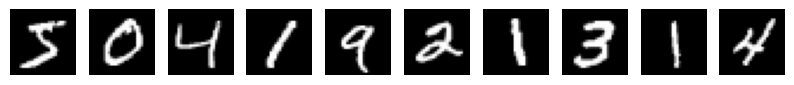

In [2]:
fig = plt.figure(figsize=(10, 10))

for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    ax.imshow(mnist[i][0], cmap="grey")
    ax.axis("off")

In [3]:
class LayerNorm(nn.Module):
    def __init__(self, latent_dim):
        super(LayerNorm, self).__init__()
        self.mean = nn.Parameter(T.zeros(latent_dim))
        self.sd = nn.Parameter(T.ones(latent_dim))

    def forward(self, x):
        return x * self.sd + self.mean

In [28]:
class VAE(nn.Module):
    def __init__(self, latent_dim=64, layers=4, input_dim=784):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(input_dim//i, input_dim//(i+1)),
                LayerNorm(input_dim//(i+1)),
                nn.LeakyReLU(0.1)
            ) for i in range(1, layers)]
        )
        self.mu = nn.Sequential(nn.Linear(input_dim//layers, latent_dim))
        self.logvar = nn.Sequential(nn.Linear(input_dim//layers, latent_dim))
        self.decoder = nn.ModuleList(
            [nn.Linear(latent_dim, input_dim//layers)] + [nn.Sequential(
                nn.Linear(input_dim//(layers-i), input_dim//(layers-i-1)),
                LayerNorm(input_dim//(layers-i-1)),
                nn.LeakyReLU(0.1)
            ) for i in range(layers-1)]
        )

    def KL(self, mean, sd):
        sd = T.clip(sd, min=1e-4, max=3)
        mean = T.clip(mean, min=1e-4, max=3)
        return (sd - 0.5 + (1+mean**2)/(2*sd.exp()**2)).mean()

    def down(self, x):
        for layer in self.encoder:
            x = layer(x)
        return self.mu(x), self.logvar(x)

    def forward(self, x):
        for layer in self.encoder:
            x = layer(x)
        self.mean = self.mu(x)  # (b, S)
        self.sd = self.logvar(x)
        kl = self.KL(self.mean, self.sd)
        self.sd = T.exp(0.5 * self.sd)
        # sample
        sample = self.mean + self.sd * T.randn_like(self.sd)
        x = sample
        for layer in self.decoder:
            x = layer(x)
        return kl, T.sigmoid(x)

In [6]:
class VAE(nn.Module):
    def __init__(self, latent_dim=64, layers=4, input_dim=784):
        super(VAE, self).__init__()
        self.mlp = nn.ModuleList([nn.Linear(input_dim, input_dim, bias=False)])

    def forward(self, x):
        for layer in self.mlp:
            x = layer(x)
        kl = x.mean() * 0
        return kl, T.sigmoid(x)

In [9]:
import torchvision.transforms as transforms
class Dataset:
    def __init__(self, d):
        self.d = d
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __getitem__(self, index):
        fn, label = self.d[index]
        if self.transform is not None:
            img = self.transform(fn)
        return img, label

    def __len__(self):
        return len(self.d)

In [10]:
bs = 32
dataloader = DataLoader(Dataset(mnist), batch_size=bs, shuffle=True)

In [16]:
data = next(iter(dataloader))[0]

In [1638]:
device = T.device("mps")

In [135]:
def beta(i):
    step = 800
    if i < step:
        return 0
    return (i % step)/step

In [12]:
def cross_entropy(x,y):
    return -(x*T.log(y+1e-7) + (1-x)*T.log(1-y + 1e-7)).mean()

In [14]:
len(dataloader)

1875

In [137]:
recon_loss = []
kl_loss = []
model = VAE(layers=4, latent_dim=32, input_dim=data[0].flatten().shape[0])
# model = T.compile(model)
opt = T.optim.AdamW(model.parameters(), weight_decay=0.01)
i = 1
for e in range(1000):
    print(f"epoch {e}")
    for img, label in dataloader:
        i += 1
        flat = img.flatten(1)

        opt.zero_grad()
        kl, y = model(flat)
        recon = cross_entropy(flat, y)
        loss = recon + kl*beta(i)

        loss.backward()
        opt.step()
        kl_loss.append(kl.item())
        recon_loss.append(recon.item())
    print(f"loss: {loss.item()}; kl: {kl.item()}; recon: {recon.item()}")

epoch 0
loss: 0.1460808366537094; kl: 0.0001308028877247125; recon: 0.14603571593761444
epoch 1
loss: 0.12189386039972305; kl: 4.208501195535064e-06; recon: 0.12189096212387085
epoch 2
loss: 0.11757775396108627; kl: 0.00015367625746876001; recon: 0.11757276207208633
epoch 3
loss: 0.11747360974550247; kl: 0.000103939906693995; recon: 0.11743450164794922
epoch 4
loss: 0.09909427911043167; kl: 7.655908120796084e-06; recon: 0.09908876568078995
epoch 5
loss: 0.09783292561769485; kl: 2.7127127395942807e-05; recon: 0.09783119708299637
epoch 6
loss: 0.10954656451940536; kl: 0.00016717228572815657; recon: 0.10947844386100769
epoch 7
loss: 0.09032570570707321; kl: 0.00030633059213869274; recon: 0.09009557217359543
epoch 8


KeyboardInterrupt: 

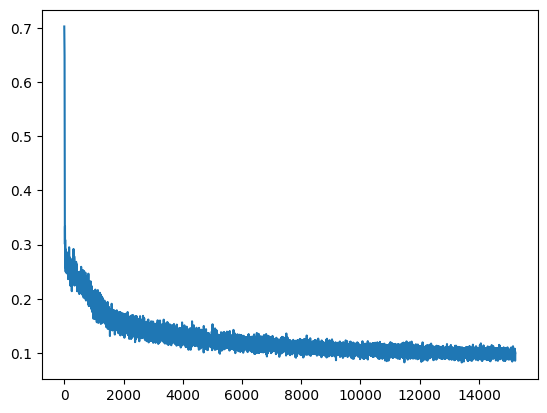

In [140]:
plt.plot(recon_loss)

In [ ]:
y.mean()

tensor(0.5125, grad_fn=<MeanBackward0>)

In [ ]:
flat.mean()

tensor(0.1151)

In [146]:
plt.imshow(y_pred.detach().cpu()[5].reshape(28, 28))

NameError: name 'y_pred' is not defined

In [185]:
p = []
labels = []
for im in mnist:
    x = Dataset(0).transform(im[0]).flatten()
    labels.append(im[1])
    for layer in model.encoder:
        x = layer(x)
    x = model.mu(x)
    p.append(x.detach())

In [182]:
p = []
for i in flat:
    x = i
    for layer in model.encoder:
        x = layer(x)
    x = model.mu(x)
    p.append(x.detach())

In [186]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2)

pca_results = pca.fit_transform(p)

In [194]:
T.vstack(p).std()

tensor(2.8574)

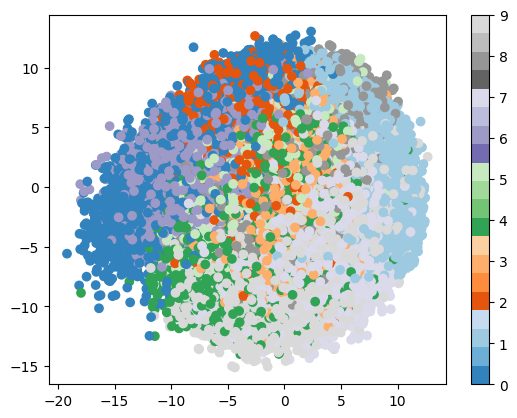

In [188]:
sc = plt.scatter(pca_results[:,0], pca_results[:, 1], c=labels, cmap="tab20c")
plt.colorbar(sc)
plt.show()

In [ ]:
x = (T.rand(32)-0.5)*2
for layer in model.decoder:
    x = layer(x)
x = T.sigmoid(x)

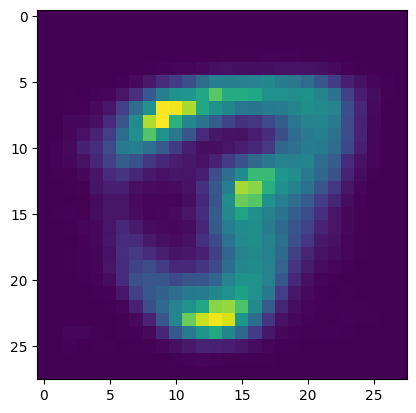

In [261]:
x = T.rand(32)*3 - 5
for layer in model.decoder:
    x = layer(x)
x = T.sigmoid(x)
plt.imshow(x.detach().reshape(28, 28))

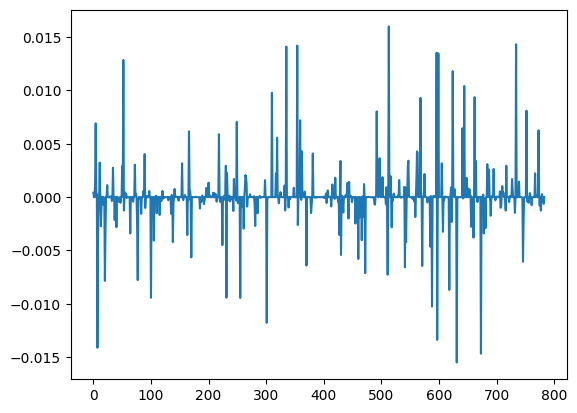

In [ ]:
plt.plot(y.detach().cpu()[0])

In [ ]:
model.mlp[0].weight

Parameter containing:
tensor([[ 0.0172,  0.0123, -0.0107,  ...,  0.0024, -0.0015,  0.0035],
        [-0.0066, -0.0215, -0.0142,  ...,  0.0016,  0.0144, -0.0030],
        [-0.0115,  0.0158, -0.0068,  ...,  0.0232, -0.0248, -0.0206],
        ...,
        [ 0.0189,  0.0121,  0.0130,  ..., -0.0130,  0.0130,  0.0135],
        [ 0.0307,  0.0161,  0.0334,  ...,  0.0317, -0.0041,  0.0101],
        [ 0.0089, -0.0033, -0.0255,  ...,  0.0291, -0.0270, -0.0065]],
       requires_grad=True)

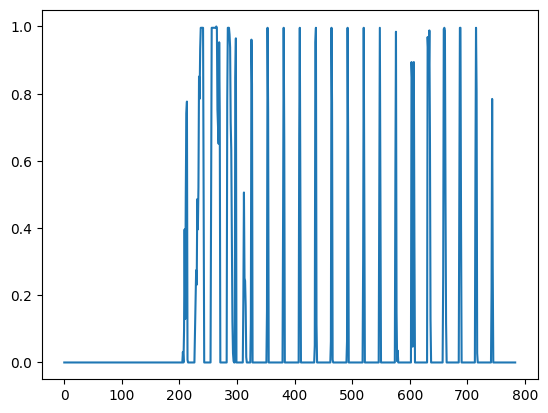

In [ ]:
plt.plot(flat[0])